# 목적

- CNN에 대한 이해 완성
- 합성곱, 풀링을 직접 구현하여 행렬 사용에 대한 이해도 높임
  - 단 일부 조건은 제한
- API와 결과를 비교
- W 값을 직접 제시(수평, 수직 커널)
  - 이 가중치가 원본이미지에 어떤 영향을 미치는지 => 어떤 특징들을 추출 강화 하는지 확인
- x, W, s, p 간에는 어떤 수식이 존재

In [51]:
import torch

torch.__version__

'1.9.0+cu102'

# CNN 핵심 기능 직접 구현

- 시각인지 과정 기본 원리
  - 눈에서 사물을 인지하는 방식은 계층적으로 진행된다
  - 눈에 있는 각각의 세포들은 각각의 역활을 가지고 사물을 인지한다
    - 지형학적으로 동일 이미지에 대한 각기 다른 정보로 이해
  - 이런 정보들이 종합되어서, 인지 범위가 뒤로 갈수록(눈의 안쪽으로 갈수록) 더 넓어진다 -> 더 큰 영역에 대한 이미지를 인식하게 된다

  - 이런 정보를 종합하여 이미지 1개를 이해하게 된다

- 이미지상의 공간 정보를 필터를 통과시켜서 특징을 추출한다 -> 눈안에 있는 세포들이 사물을 이해하는 과정을 본떠서 만든  방식이다
- 층(계층적, 단계) -> 눈앞에 세포가 인지하는 범위와 눈뒤쪽에 세포가 인지하는 범위가 다르므로 이를 구현한것이다

# 이미지 데이터 준비

In [52]:
import matplotlib.pyplot as plt
# Pillow
from PIL import Image

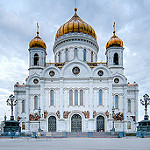

In [53]:
img = Image.open('/content/drive/MyDrive/edu.kenshi/2021/품질재단/DL/res/torch3.png')
img

In [54]:
import numpy as np

In [55]:
# (150,150)=(H, W)
img.size, np.array( img ).shape
# 채널수는 배열로 변환해서 확인 -> 3 채널 -> 칼라

((150, 150), (150, 150, 3))

In [56]:
# 칼라 이미지를 그레이 스케일로 변환
# L = R*(299/1000) + G*(587/1000) + B*(114/1000)
# R,G,B의 지분을 커스텀하게 조절하는것에 따라 달라질수 있다
img = img.convert("L")

# 이미지가 1 채널로 값을 가지고 있다!!
img.size, np.array(img).shape

((150, 150), (150, 150))

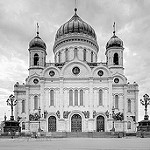

In [57]:
img

# 이미지를 텐서로 표현

In [58]:
img_tensor = torch.Tensor( np.array( img ) )
img_tensor.size()

torch.Size([150, 150])

In [59]:
# 이 이미지의 데이터 확인
img_tensor

tensor([[212., 213., 215.,  ..., 197., 199., 200.],
        [215., 216., 216.,  ..., 197., 199., 200.],
        [214., 215., 216.,  ..., 196., 197., 198.],
        ...,
        [171., 171., 172.,  ..., 163., 166., 161.],
        [174., 174., 174.,  ..., 173., 175., 168.],
        [168., 168., 168.,  ..., 158., 159., 150.]])

In [60]:
# 텐서내에서 최소 ( 0 ), 최대값 ( 255 )
img_tensor.min(), img_tensor.max()

(tensor(0.), tensor(255.))

# 합성곱 구현

## 합성곱에 필요한 재료(필수정도만)

### 커널, 가중치

In [61]:
# 커널(필터) : 가중치(W)를 공용파라미터로 가진 커널(필터)
#              눈안에 한개의 세포, 이 1개의 세포가 전체 이미지의 한부분을 인지 -> 공간정보추출
# 전제 : 수평(직) 커널 -> 커널이 가진 W의 성향이 수평(직)정보를 추출하는데 있다 -> 수평(직) 정보 추출
#        빛의 방향을 고려하여서 설계했다 
# 왼쪽 혹은 오른족이 어둡게 나올것이다(그림자)
kernel = torch.Tensor( [
  [ 1, 0, -1 ],
  [ 1, 0, -1 ],
  [ 1, 0, -1 ]                        
] )
kernel

tensor([[ 1.,  0., -1.],
        [ 1.,  0., -1.],
        [ 1.,  0., -1.]])

In [62]:
# 수평커널
kernel.T

tensor([[ 1.,  1.,  1.],
        [ 0.,  0.,  0.],
        [-1., -1., -1.]])

In [63]:
# 수평커널 통과한 이미지 + 수직커널을 통과한 이미지 => 외곽선이 디텍팅된 이미지가 될것이다....

### 이미지 원재로 정보 추출

In [64]:
# 이미지 높이, 이미지 너비
height, width = img_tensor.size()
height, width

(150, 150)

### 커널의 이동량

In [65]:
# stride ->  이미지 공간상에 커널을 슬라이딩하는 양 -> 좌우, 상하로 반복적으로 진행
# 왼쪽 -> 오른쪽, 위에서 -> 아래 => for ~ for
# 전부다 이동량이 동일하다
stride = 1

### 이미지상의 좌표

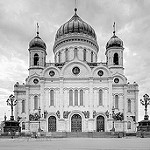

In [66]:
# 이미지 좌표는 4/4분면을 따라간다, 왼쪽 상단이 (0,0)을 의미한다
# 커널(필터)는 0,0에부터 출발
img

## 실구현

In [67]:
# 최종은 함수로 구현 
# 이미지상에 커널이 이동한다
# 커널하고 겹쳐진 이미지 공간상의 정보를 추출한다 => 그래야 커널과 계산이 가능

# 커널의 높이, 너비
k_h, k_w = kernel.size()

# 세로 방향 스캔(연산 처리)
# 실습 1 : 아래 표현을 구하시오, 0부터 체크, stride 만큼 이동
# 세로 이동량 = 이미지원본높이(height)-커널크기높이(k_h)+1 <- 경계값은 range 할때 포함이 않되므로
for i in range( 0,  height-k_h+1, stride ):# 위에서 부터 한칸씩 아래로 내려간다
  # 가로 방향 스캔(연산 처리)
  tmp = list()
  for j in range( 0, width-k_w+1, stride):# 왼쪽에서 오른쪽으로 이동
    # 1. 이미지 공간상의 정보 추출 (커널이 겹쳐져 있는 이미지의 정보)
    # 실습 커널과 겹쳐지는 이미지 공간 정보 추출 코드를 작성하시오 -> img_tensor
    img_target = img_tensor[ i:(i+k_h) , j:(j+k_w) ]
    print( img_target )
    # 2. 커널
    print( kernel )
    # 3. 연산 : 같은 자리에 위치한 원소끼리 곱한다 => 모두 더한다
    # 3-1 같은 자리에 위치한 원소끼리 곱한다
    print( img_target*kernel )
    # 3-2 텐서상에 있는 모든 요소를 더한다 -> 1개의 값
    print( torch.sum( img_target*kernel ) )
    tmp.append( torch.sum( img_target*kernel ) )
    #pass
    break
  #pass
  break

tensor([[212., 213., 215.],
        [215., 216., 216.],
        [214., 215., 216.]])
tensor([[ 1.,  0., -1.],
        [ 1.,  0., -1.],
        [ 1.,  0., -1.]])
tensor([[ 212.,    0., -215.],
        [ 215.,    0., -216.],
        [ 214.,    0., -216.]])
tensor(-6.)


In [68]:
img_tensor.size()

torch.Size([150, 150])

In [69]:
k_h, k_w = kernel.size()

# padding을 고려하지 않았다!! -> stride를 1칸씩 처리 -> valid 형태로 결과가 나왔다 -> 이미지 크기가 줄었다
# 커널 크기에 영향
newImg = list()
for i in range( 0,  height-k_h+1, stride ):
  tmp = list()
  for j in range( 0, width-k_w+1, stride):    
    tmp.append( torch.sum( img_tensor[ i:(i+k_h) , j:(j+k_w) ]*kernel ) )
  #print( tmp )
  newImg.append( tmp )
  #break

conv1_img = torch.Tensor( newImg )
conv1_img.size()

torch.Size([148, 148])

### 합성곱층의 함수화

In [70]:
def convolution_func( x, kernel, stride=(1,1) ):
  '''
    - 내가 정의한 합성곱층이다
    x : 원본이미지 혹은 이전층의 입력 이다
    kernel : 이미지상을 통과하는 커널(가중치 W를 가지고 있다)
  '''
  # 입력 데이터의  shape 
  x_h, x_w = x.size()
  k_h, k_w = kernel.size()
  s_h, s_w = stride

  # padding을 고려하지 않았다!! -> stride를 1칸씩 처리 -> valid 형태로 결과가 나왔다 -> 이미지 크기가 줄었다
  # 커널 크기에 영향
  newImg = list()
  for i in range( 0,  x_h-k_h+1, s_h ):
    tmp = list()
    for j in range( 0, x_w-k_w+1, s_w):   
      # 이 부분을 리뉴얼 하면 새로운 합성곱 스타일을 만들수도 있다 
      tmp.append( torch.sum( x[ i:(i+k_h) , j:(j+k_w) ]*kernel ) )
    newImg.append( tmp )

  return torch.Tensor( newImg )  

In [71]:
img_tensor

tensor([[212., 213., 215.,  ..., 197., 199., 200.],
        [215., 216., 216.,  ..., 197., 199., 200.],
        [214., 215., 216.,  ..., 196., 197., 198.],
        ...,
        [171., 171., 172.,  ..., 163., 166., 161.],
        [174., 174., 174.,  ..., 173., 175., 168.],
        [168., 168., 168.,  ..., 158., 159., 150.]])

In [72]:
# 수직 커널을 통과한 합성곱 연산 결과물
vertical_conv = convolution_func( img_tensor, kernel )
vertical_conv

tensor([[ -6.,  -3.,   3.,  ...,  -8., -10.,  -8.],
        [ -6.,  -4.,  -1.,  ...,  -7.,  -7.,  -4.],
        [ -9., -10.,  -8.,  ...,  -3.,  -1.,   1.],
        ...,
        [  0.,   1.,   2.,  ...,   2.,  -1.,   5.],
        [ -1.,  -1.,   0.,  ...,   4.,   2.,   8.],
        [ -1.,  -2.,   0.,  ...,   4.,   6.,  15.]])

In [73]:
# 수평 커널을 통과한 합성곱 연산 결과물
horizental_conv = convolution_func( img_tensor, kernel.T )
horizental_conv

tensor([[ -5.,  -4.,  -3.,  ...,   5.,   5.,   5.],
        [ 16.,  13.,   7.,  ...,   3.,   8.,  13.],
        [ 28.,  23.,  14.,  ...,   2.,   8.,  15.],
        ...,
        [-27., -30., -32.,  ...,  19.,  21.,  22.],
        [-42., -44., -46.,  ...,  -2.,   1.,   6.],
        [ 10.,  11.,  13.,  ...,  15.,  17.,  23.]])

- 내가 만든 CNN을 경계선을 강화하기 위해서 
  - 합성곱 통과시, 수평, 수직을 각각 통과해서 
  - 2개를 합성하여서
  - 풀링으로 전달하는 컨볼류션으로 진행하겟다

### 현재까지 산출물 시각화

- 현재는 feature map을 시각화 한것이다

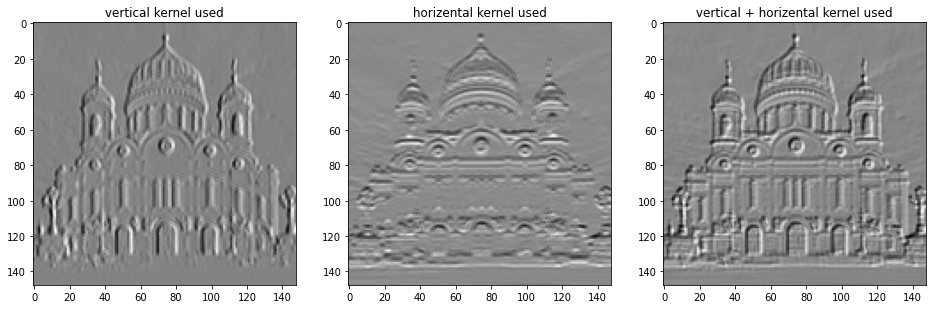

In [74]:

# 수직/수평 커널 결과 확인
fig, (ax1, ax2, ax3) = plt.subplots( 1, 3, figsize=(16,9) )

# 수직 커널 시각화
# 텐서를 그냥 넣어도 시각화가 된다
# 빛이 방향이 바라보는 관점에서 보면 오른족에서 왼쪽으로 빛이 투과된다
ax1.imshow( vertical_conv, cmap='binary' )
ax1.set_title(' vertical kernel used ')

# 수평 커널 시각화
ax2.imshow( horizental_conv, cmap='binary' )
ax2.set_title(' horizental kernel used ')

# 수평 + 수직 > 사물에 대한 경계선이 명확, 뒷배경이 처리
ax3.imshow( vertical_conv + horizental_conv, cmap='binary' )
ax3.set_title(' vertical + horizental kernel used ')

plt.show()

# 배경색이 탁하다 => 전체적인 색톤을 화이트 블랙(경계선) 처리하고 싶다
# 전체적인 이미지 데이터를 => 조정해라 => 활성화 함수를 통과시켜라 => 데이터 조정이 진행된다

### activation map 시각화


- feature map 데이터를 활성화 함수를 통과시켜서 
- 데이터를 조정(의도성을 가지고, 색상을 음수는 0, 양수는 그대로 => relu)

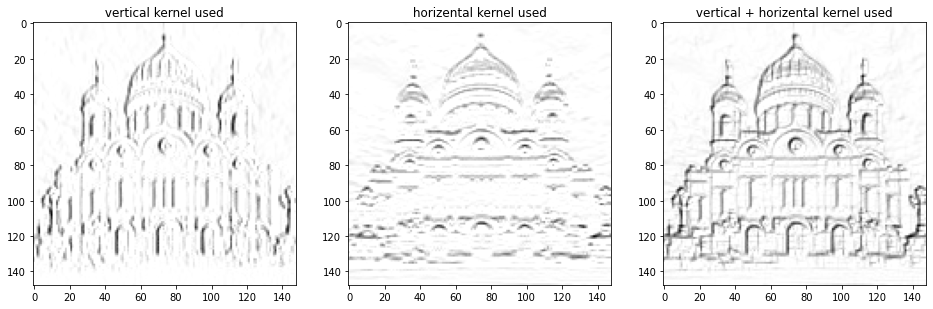

In [75]:
fig, (ax1, ax2, ax3) = plt.subplots( 1, 3, figsize=(16,9) )
#fig.figure( )

ax1.imshow( torch.relu( vertical_conv ), cmap='binary' )
ax1.set_title(' vertical kernel used ')


ax2.imshow( torch.relu(horizental_conv), cmap='binary' )
ax2.set_title(' horizental kernel used ')

# 각각 relu를 처리하고 합산할것인지
# 합산후에 relu를 처리할것인지 결과는 다를수 있다
ax3.imshow( torch.relu( vertical_conv ) + torch.relu(horizental_conv), cmap='binary' )
ax3.set_title(' vertical + horizental kernel used ')

plt.show()

# 음수값들을 다 제거하면서, 모두 0이 되었다 (학습 효율적인 측면)
# 경계선 좀더 정확하게 체킹해 낼수 있을 것이다 

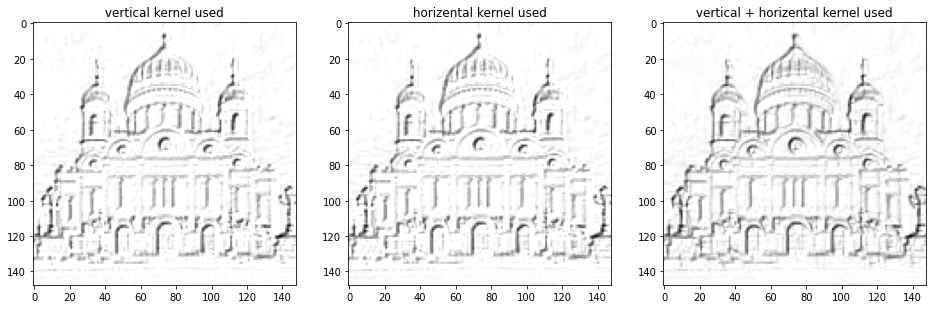

In [76]:
fig, (ax1, ax2, ax3) = plt.subplots( 1, 3, figsize=(16,9) )

# 활성화(수직 + 수평)
ax1.imshow( torch.relu( vertical_conv  + horizental_conv), cmap='binary' )
ax1.set_title(' vertical kernel used ')


# 활성화(수평 + 수직)
ax2.imshow( torch.relu( horizental_conv + vertical_conv ), cmap='binary' )
ax2.set_title(' horizental kernel used ')


# 활성화(수평) + 활성화(수직)
ax3.imshow( torch.relu( vertical_conv ) + torch.relu(horizental_conv), cmap='binary' )
ax3.set_title(' vertical + horizental kernel used ')

plt.show()
# 경우에 따라서 경과가 상이하게 나으므로 적절하게 잘 선택
# 이 이미지가 타지마할 사원임을 잘 알겠금 특징점들을 잘뽑게 구성하는게 정답

## 실제 API와 비교 검증 수행

In [77]:
# 모듈가져오기
import torch.nn as nn

In [79]:
# 칼라였다면 (150,150,3)
# img_tensor의 채널수는 1이다
img_tensor.size()

torch.Size([150, 150])

In [81]:
# x를 준비 => 이미지 데이터 포멧 => NHWC or NCHW ( channel_last or first )
# 기본 포멧 : NCHW
# (1, 1, h, w)
# 차원 변경 진행
# 구현하시오 -> view를 통해서 구현
h, w = img_tensor.size()
h, w
tmp = img_tensor.view( 1, 1, h, w)
tmp.size()

torch.Size([1, 1, 150, 150])

In [83]:
# expand() 차원확장할때 사용
img_tensor = img_tensor.expand( 1, 1, h, w )
img_tensor.size()

torch.Size([1, 1, 150, 150])

In [84]:
# 원본이미지로부터 정보 추출
batch, in_channel, h, w = img_tensor.size()

In [86]:
out_channels = 1
kernel_size  = 3 # 세로, 가로 행렬크기가 동일
stride       = 1 # 세로, 가로 행렬크기가 동일

In [87]:
conv_layer = nn.Conv2d(
  in_channels  = in_channel,
  out_channels = out_channels,
  kernel_size  = kernel_size,
  stride       = stride,
  bias         = False
) 

In [88]:
# 수직커널 혹은 수평커널이라는 W값이 반영이 않되어 있다
# 가중치가 들어가 있지 않은 합성곱층이다
conv_layer

Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)

In [89]:
# 가중치 반영
conv_layer.weight.type()

'torch.FloatTensor'

In [91]:
# 기본값이 API에는 세팅되어 있다
conv_layer.weight.data

tensor([[[[ 0.1394,  0.0225,  0.0182],
          [-0.0972,  0.1343, -0.0760],
          [-0.0058, -0.2162,  0.0025]]]])

In [90]:
conv_layer.weight.data.size()

torch.Size([1, 1, 3, 3])

In [92]:
# 준비된 수평 커널 -> 2D:(3,3) => 4D:(1, 1, 3, 3) 변경 필요
kernel.size()

torch.Size([3, 3])

In [94]:
# size( demension ) : 차원별로 값을 추출
kernel.size(0), kernel.size(1)

(3, 3)

In [95]:
# 현재 준비된 합성곱층의 가중치값을 수직커널의 가중치 값으로 대체
conv_layer.weight.data = kernel.expand( 1, 1, kernel.size(0), kernel.size(1) )
conv_layer.weight.data

tensor([[[[ 1.,  0., -1.],
          [ 1.,  0., -1.],
          [ 1.,  0., -1.]]]])

In [96]:
# 합성곱층에 x를 입력
convs = conv_layer( img_tensor ) 

# 직접 구현한 합성곱측의 산출물과 api 함수를 이용하여 동일조건으로 수행시 산출물  shape들중 (h, w)는 동일
convs.type(), convs.size()

('torch.FloatTensor', torch.Size([1, 1, 148, 148]))

In [97]:
# convs에서 차원 값이 1인 차원을 제거하시오 -> (1,1,148,148) => (148,148)
convs.squeeze().size()

torch.Size([148, 148])

In [98]:
convs.squeeze()

tensor([[ -6.,  -3.,   3.,  ...,  -8., -10.,  -8.],
        [ -6.,  -4.,  -1.,  ...,  -7.,  -7.,  -4.],
        [ -9., -10.,  -8.,  ...,  -3.,  -1.,   1.],
        ...,
        [  0.,   1.,   2.,  ...,   2.,  -1.,   5.],
        [ -1.,  -1.,   0.,  ...,   4.,   2.,   8.],
        [ -1.,  -2.,   0.,  ...,   4.,   6.,  15.]],
       grad_fn=<SqueezeBackward0>)

In [99]:
vertical_conv

tensor([[ -6.,  -3.,   3.,  ...,  -8., -10.,  -8.],
        [ -6.,  -4.,  -1.,  ...,  -7.,  -7.,  -4.],
        [ -9., -10.,  -8.,  ...,  -3.,  -1.,   1.],
        ...,
        [  0.,   1.,   2.,  ...,   2.,  -1.,   5.],
        [ -1.,  -1.,   0.,  ...,   4.,   2.,   8.],
        [ -1.,  -2.,   0.,  ...,   4.,   6.,  15.]])

In [100]:
convs.squeeze() == vertical_conv

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [101]:
148*148

21904

In [102]:
# True => 1, False => 0
# 합산 => 148*148
torch.sum(  convs.squeeze() == vertical_conv )
# 직접 만든 함수와 API로 만든 함수가 실제적으로 일치한다(동일하게 작동한다)

tensor(21904)

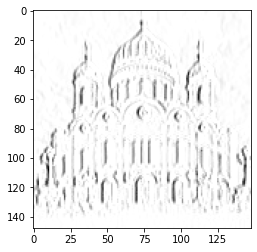

In [104]:
# 텐서를 직접 그리기
# detach() 는 학습 진행시 최적화에서 미분이 작동하게 되는데 이를 중단하는 역활
# 텐서 자체가 현재 이런 내부 계산이 작동되도록 세팅되어 잇다 -> 이런 작용을 락을 걸어서 
# 출력 작업을 할수 있게 처리하는 함수
plt.imshow( torch.relu( convs.squeeze() ).detach().numpy(), cmap='binary' )
plt.show()

In [106]:
activation_map = torch.relu( convs )
activation_map.size()

torch.Size([1, 1, 148, 148])

# k(W), s, p 이들 사이의 관계식

- 성분
  - S : stride 이동량
  - P : padding  
  - K : kernel 크기
  - h : 원본 이미지의 높이
  - w : 원본 이미지의 너비
- 커널이 이미지를 통과하고 나서 생성된 이미지의 크기
  - H = **( ( h + 2*P - K )/S ) + 1**

    - ( ( 150 + 2*0 - 3 )/1 ) + 1
    - ( ( 147 )/1 ) + 1
    - 147 + 1
    - 148
    
  - W = **( ( w + 2*P - K )/S ) + 1**

# 최대 풀링 구현

- 특징 강화

In [107]:
activation_map

tensor([[[[ 0.,  0.,  3.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  1.],
          ...,
          [ 0.,  1.,  2.,  ...,  2.,  0.,  5.],
          [ 0.,  0.,  0.,  ...,  4.,  2.,  8.],
          [ 0.,  0.,  0.,  ...,  4.,  6., 15.]]]], grad_fn=<ReluBackward0>)

In [108]:
# 커널사이즈 
kernel_size = 2
# 이동량
stride_size = 2

In [109]:
activation_map.size()

torch.Size([1, 1, 148, 148])

### maxpool을 api를 이용하여 구현

In [112]:
# 1. 샘플 : NCHW 형식으로 준비
tmp = torch.arange(0, 16).view( 1, 1, 4, 4)
tmp

tensor([[[[ 0,  1,  2,  3],
          [ 4,  5,  6,  7],
          [ 8,  9, 10, 11],
          [12, 13, 14, 15]]]])

- 목표
  - 커널이 이동하면서 해당 영역의 최대값을 대표값을 취하게 구성
  - [ 5,  7 ]
  - [ 13, 15]

In [114]:
# 2. unfold => 이용하여 maxpool 작업을 할 대상을 한개의 차원으로 모은다
# dimension => 2 or 3, size =>2(kernel), step=>2(stride)
tmp.unfold( 2, 2, 2 )

tensor([[[[[ 0,  4],
           [ 1,  5],
           [ 2,  6],
           [ 3,  7]],

          [[ 8, 12],
           [ 9, 13],
           [10, 14],
           [11, 15]]]]])

In [115]:
# 풀링의 대상이 되는 요소끼리 뭉쳐졌다 -> 차원을 줄이면서 max -> ... 반복
tmp.unfold( 2, 2, 2 ).unfold( 3, 2, 2 )

tensor([[[[[[ 0,  1],
            [ 4,  5]],

           [[ 2,  3],
            [ 6,  7]]],


          [[[ 8,  9],
            [12, 13]],

           [[10, 11],
            [14, 15]]]]]])

In [116]:
# 4D -> 6D
tmp.unfold( 2, 2, 2 ).unfold( 3, 2, 2 ).size()

torch.Size([1, 1, 2, 2, 2, 2])

In [121]:
# 6D -> 5D
tmp.unfold( 2, 2, 2 ).unfold( 3, 2, 2 ).max(-1)[0].size()

torch.Size([1, 1, 2, 2, 2])

In [122]:
# 차원을 닷기 줄여가면서 최대값을 추출
# 각 요소의 최하위 차원에서 max를 구한다 : max(-1)
tmp.unfold( 2, 2, 2 ).unfold( 3, 2, 2 ).max(-1)[0]

tensor([[[[[ 1,  5],
           [ 3,  7]],

          [[ 9, 13],
           [11, 15]]]]])

In [123]:
# max pooling 완성
tmp.unfold( 2, 2, 2 ).unfold( 3, 2, 2 ).max(-1)[0].max(-1)[0]

tensor([[[[ 5,  7],
          [13, 15]]]])

In [124]:
# 최종 풀링 처리 함수
def maxPooling( x, kSize, stride=None ):
  if not stride: # 이동량을 제시하지 않으면, 커널과 동일 크기로 처리된다
    stride = kSize
  # 최대 풀링 처리
  # case 1 => for ~ for을 이용하여 커널을 이동시키면서 해당 위치에 
  #           존재하는 데이터를 추출하여 거기서 max값을 취한다
  # case 2 => 행렬의 연산 혹은 api를 활용해서 max값을 취한다
  return x.unfold( 2, kSize, stride ).unfold( 3, kSize, stride ).max(-1)[0].max(-1)[0]
  pass

pool_map = maxPooling( activation_map, kernel_size, stride_size )
# (1,1,74,74) 목표
pool_map.size()

torch.Size([1, 1, 74, 74])

## API를 사용하여 검증

In [125]:
maxPool_layer = nn.MaxPool2d( kernel_size, stride_size )
maxPool_layer

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [126]:
pooling_map = maxPool_layer( activation_map )
pooling_map.size()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([1, 1, 74, 74])

In [127]:
pool_map == pooling_map

tensor([[[[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]]]])

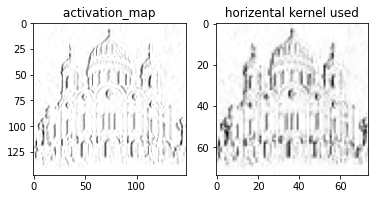

In [130]:
# 풀링층 통과한 결과물과 비교
fig, (ax1, ax2) = plt.subplots( 1, 2 )#, figsize=(16,9) )

# 합성곱층을 통과하여 활성화 함수를 통과한 활성화맵 -> 특징 추출
ax1.imshow( activation_map.squeeze().detach().numpy(), cmap='binary' )
ax1.set_title(' activation_map ')

# 풀링층을 통과한 맵 -> 특징 강화
ax2.imshow( pooling_map.squeeze().detach().numpy(), cmap='binary' )
ax2.set_title(' horizental kernel used ')

plt.show()
# 경계값은 더 진해졌다 -> 강화되었다
# 다만 이미지 자체는 거칠어 졌다. -> 좀 깨져 보인다